<a href="https://colab.research.google.com/github/SudeepSarkar/Computer-Vision-Course/blob/main/Lecture_3_Mean_Shift_Clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## The mean shift algorithm

"Mean shift is a **non-parametric** feature-space analysis technique for locating the maxima of a density function, a so-called **mode-seeking algorithm**. Application domains include cluster analysis in computer vision and image processing." -- https://en.wikipedia.org/wiki/Mean_shift

Think of mean-shift clustering as k-means but you don't have to specify the number of clusters. (You have to specify the **bandwidth** but that can be automated.) *Core algorithmic task*: Efficiently find the **peaks** or **modes** of a distribution given a set of samples, unlike the means of a distribution as done by k-means or EM. 

**Reference material**: 
1. Section 5.3.2 of text book
2. D. Comaniciu and P. Meer, "[Mean shift: a robust approach toward feature space analysis](https://ieeexplore.ieee.org/document/1000236)," in IEEE Transactions on Pattern Analysis and Machine Intelligence, vol. 24, no. 5, pp. 603-619, May 2002, doi: 10.1109/34.1000236.
3. https://en.wikipedia.org/wiki/Mean_shift


Let $\mathbf{x}_i$ represent the vector representing a pixel in terms of color or other attributes. We have seen how the probability distribution of this pixel feature vector can be represented using a Gaussian mixture model (GMM) that is specified by the paramters of the Gaussian components and the mixture probabilities. Here we will use a non-parameteric probability density function for the pixel values, called kernel distribution (or sometimes [Parzen](https://en.wikipedia.org/wiki/Emanuel_Parzen) distribution). The density function does not have any parameters (This is not quite right. We do need one parameter, as we shall see. However, this single parameter need is way less than needed for GMM, so close enough to zero.)

**Kernel distribution** is an estimate of a *continuous* probability density function from samples. It is achieved by replacing a continuous function, which we will call the kernel function $G(\mathbf{x})$ at **each** sample and adding them up. 

It effectively gives us a continuous interpolation of the data between the samples. 

The most used kernel function is a Gaussian function.
    \begin{equation}
        f(\mathbf{x}) = c \sum_{i=1}^{N} G (\mathbf{x} - \mathbf{x}_i) = c \sum_{i=1}^N \exp \left( -\frac{||\mathbf{x} - \mathbf{x}_i||^2}{2 h^2} \right )
    \end{equation}

The constant $c$ is a normalizing constant to make the function integrate out to one. For a vector valued sample, this is basically a sum of Gaussian balls centered on the samples.




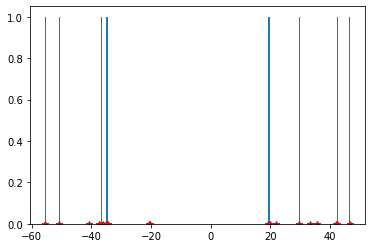

In [4]:
# Generate n_sample number of random 1D samples.
import numpy as np
import matplotlib.pyplot as plt

n_clusters = 2
n_samples = 10
m = np.random.uniform(-35, 35, (n_clusters, 1))

slices = [np.random.normal(m[i], 10, n_samples)
          for i in range(n_clusters)]
# slices is an array of array
data = np.concatenate(slices).astype(np.float32)

plt.bar(data, np.ones(data.shape),width=0.1)
plt.plot(data, np.zeros(data.shape), 'r*');

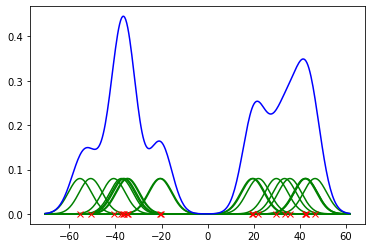

In [6]:
# place a Gaussian function at each sample and add

def G(y, s) :
  z = (1/(np.sqrt(2*np.pi)*s))* np.exp(-(y**2)/(2*s*s))
  return(z)

h = 5
x = np.linspace(-3*h+np.min(data), 3*h+np.max(data),num=300)
p = np.zeros(x.shape)
for i in range(data.shape[0]) :
  G_i = G((x - data[i]), h)
  plt.plot(x, G_i, 'g')
  p = p+G_i

# plot the kernel density function
plt.plot(x, p, 'b')

# plot the initial data sample
plt.plot(data, np.zeros(data.shape), 'rx');



We have to find the peaks of this kernel density function **without** "computing" the kernel density function for all points as we did above.

**Multiple restart gradient ascent**: Our approach to finding the peaks in this continuous function would be to start from a random point and then to move it iteratively towards a peak. Ideally, we would like to start from many different points so that we are able to that converge around all the available peaks. How many samples should we start from? That is an issue that is needs to be looked at during implementation time. This is a kin to hill climbing but from many different points. 
    
Another way to visualize this process is to imagine throwing a random number of particles on this continuous function and then moving these particles up the hill wherever they are placed. The idea is that overtime the particles will accumulate on the hilltops nearest to them. Let us first see how we can quantify the step we need to take at each iteration from each particle or starting point.
    
For each particle (or estimate of a possible peak, $\mathbf{y}_k$, we modify it by an uphill step, which is estimated by the gradient of the function at $\mathbf{y}_k$.

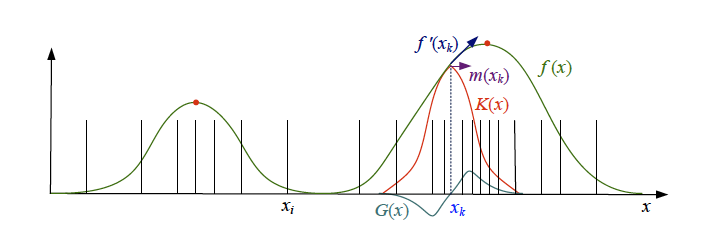
    


So, first we need to an expression of the gradient of the continuous function $f(\mathbf{x})$. Note that the function is a scalar value define over a vector field.

**The 1D case:** The expression of a 1D kernel density function is given by:
\begin{equation}
        f(x) = c \sum_{i=1}^N \exp \left( -\frac{(x-x_i)^2}{2 h^2} \right )
\end{equation}

The first derivative of this kernel function is given by
\begin{equation}
        f^{'}(x) = c \frac{d f(x)}{dx} = c\sum_{i=1}^N - \frac{x-x_i}{h^2} \exp \left( \frac{(x-x_i)^2}{2 h^2} \right )
\end{equation}
    
Note that this is equivalent to placing a first derivative of a Gaussian function at each sample point.
    


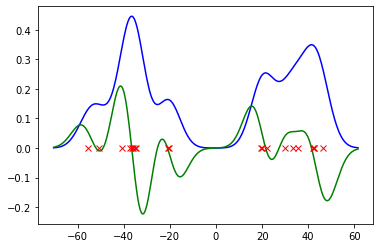

In [7]:
# place a derivative of a Gaussian function at each sample and add

def G_prime(y, s) :
  z = -(1/(np.sqrt(2*np.pi)*s*s))* (y) * np.exp(-(y**2)/(2*s*s))
  return(z)

h = 5
x = np.linspace(-3*h+np.min(data), 3*h+np.max(data),num=300)
p = np.zeros(x.shape)
p_prime = np.zeros(x.shape)
for i in range(data.shape[0]) :
  G_i = G((x - data[i]), h)
  G_prime_i = G_prime((x - data[i]), h)
  p_prime = p_prime+G_prime_i
  p = p + G_i

# plot the kernel density function
plt.plot(x, p, 'b')

# plot the kernel density function
plt.plot(x, p_prime, 'g')

# plot the initial data sample
plt.plot(data, np.zeros(data.shape), 'rx')



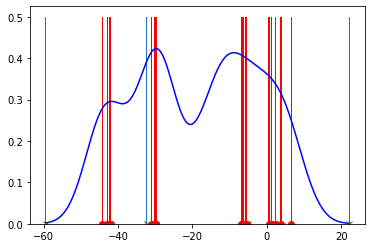

In [ ]:
# 1 D illustration of the mean shift

# plot the kernel density function from the previous cell
plt.plot(x, p, 'b')

y_k = np.linspace(-3*h+np.min(data), 3*h+np.max(data),num=4)

# plot values of the initial estimate of peak locations
plt.plot(y_k, np.zeros(y_k.shape), 'gx')
plt.bar(y_k, 0.5*np.ones(y_k.shape), width=0.2)

for iteration in range (5) :
    numerator = np.zeros(y_k.shape)
    denominator = np.zeros(y_k.shape)
    for i in range(data.shape[0]) :
      G_i = G((y_k - data[i]), h)
      xG_i = data[i]*G_i
      numerator = numerator +  xG_i
      denominator = denominator + G_i
    y_k = numerator/denominator

    plt.plot(y_k, np.zeros(y_k.shape), 'ro')
    plt.bar(y_k, 0.5*np.ones(y_k.shape), width=0.3, color='r')


# plot the initial data sample
# plt.plot(data, np.zeros(data.shape), 'rx')


## Lecture 3 - HW or In Class Assignment # 1

There are various way to initialize the potential location of the peaks. In the code **above** random points are picked within a range. Change the code to randomly pick some points from the data itself. That is, some random points of from the data itself is taken as the potential peak locations. Show the code some output plots for different random choices.

# n dimensional mean shift derivation

\begin{eqnarray}
        \nabla f(\mathbf{x}) & =  & c \sum_{i=1}^N - \frac{\mathbf{x}-\mathbf{x}_i}{h^2} \exp \left( \frac{||\mathbf{x}-\mathbf{x}_i||^2}{2 h^2} \right ) \\
        & = & c \sum_{i=1}^N - \frac{\mathbf{x}-\mathbf{x}_i}{h^2} G (\mathbf{x}-\mathbf{x}_i)
\end{eqnarray}

\begin{eqnarray}
        \nabla f(\mathbf{x}) & =  & \frac{c}{h^2}\sum_{i=1}^N - (\mathbf{x}-\mathbf{x}_i)G (\mathbf{x}-\mathbf{x}_i)\\
        & = & \frac{c}{h^2}\sum_{i=1}^N 
        - \mathbf{x}   G (\mathbf{x}-\mathbf{x}_i)
        + \mathbf{x}_i G (\mathbf{x}-\mathbf{x}_i) \\
        & = & \frac{c}{h^2} \left ( - \mathbf{x} \sum_{i=1}^N 
           G (\mathbf{x}- \mathbf{x}_i)
        + \sum_{i=1}^N \mathbf{x}_i G (\mathbf{x}-\mathbf{x}_i) \right) \\
        & = & \frac{c}{h^2} \left(\sum_{i=1}^N G (\mathbf{x}-\mathbf{x}_i) \right )
        \left ( - \mathbf{x}  + \frac{ \sum_{i=1}^N  \mathbf{x}_i G (\mathbf{x}-\mathbf{x}_i)}{ \sum_{i=1}^N G (\mathbf{x}-\mathbf{x}_i) } \right ) \\
        & = & \left [ \frac{c}{h^2} \sum_{i=1}^N  G (\mathbf{x}-\mathbf{x}_i) \right ]
        \left ( \frac{\sum_{i=1}^N  \mathbf{x}_i G (\mathbf{x}-\mathbf{x}_i)}{
        \sum_{i=1}^N G (\mathbf{x}-\mathbf{x}_i) } - \mathbf{x} \right )
\end{eqnarray} 
    
Note that in the last expression above, the term in the square bracket is a scalar quantity, while the term in parenthesis is a vector. The direction of the vector is the direction of the gradient. We will denote this vector by $\mathbf{m}(\mathbf{x})$.
    
\begin{equation}
        \mathbf{m}(\mathbf{x}) = \left ( \frac{\sum_{i=1}^N  \mathbf{x}_i G (\mathbf{x}-\mathbf{x}_i)}{
        \sum_{i=1}^N G (\mathbf{x}-\mathbf{x}_i) } - \mathbf{x} \right )
\end{equation}
    
Now that we have an expression for the gradient vector, we can use it to modify the current estimate of the peak denoted by $\mathbf{y}_k$.
    
\begin{equation}
        \mathbf{y}_{k+1} = \mathbf{y}_k + \mathbf{m}(\mathbf{y}_k) =  \frac{\sum_{i=1}^N  \mathbf{x}_i G (\mathbf{y}_k-\mathbf{x}_i)}{
        \sum_{i=1}^N G (\mathbf{y}_k-\mathbf{x}_i) }
\end{equation}
    
 The above question is basically saying that the new estimate of the peak location is the weighted mean of the sample, $\mathbf{x}_i$. The weights are local because the Gaussian function is locally weighted or has high values only with a small region around the center.

Note that the updated points is the weighted average of all the points. The weights of each point is inversely proportional to the distance of the point from the current estimate of the peak. This weighted average will be effected by points that are nearby. Intuitively, the above method works because by definition you have more samples around the peaks and a random starting point will be pulled towards denser set of points.
    


# Other possible kernel functions
   


Although the above is a derivation for the Gaussian kernel, Comaniciu and Meer (2002) has shown that this also works for other kernel functions as long as they are monotonically decreasing with distance from the center. Another kernel functions studied by them was the Epamechnikov kernel that is defined over the unit ball given by:
    
\begin{equation}
        E(\mathbf{x}-\mathbf{x}_i) = \max \left ( 0, 1 - \frac{||\mathbf{x}-\mathbf{x}_i||^2}{h^2} \right )
\end{equation}


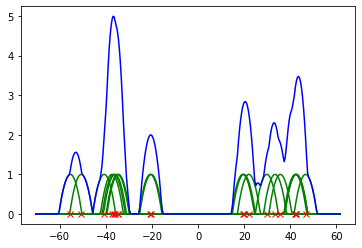

In [8]:
# place a Epamechnikov function at each sample and add

def Ep(y, s) :
  z = np.maximum(0, 1 - (y**2)/(h*h))
  return(z)

h = 5
x = np.linspace(-3*h+np.min(data), 3*h+np.max(data),num=300)
p = np.zeros(x.shape)
for i in range(data.shape[0]) :
  G_i = Ep((x - data[i]), h)
  plt.plot(x, G_i, 'g')
  p = p+G_i

# plot the kernel density function
plt.plot(x, p, 'b')

# plot the initial data sample
plt.plot(data, np.zeros(data.shape), 'rx')



# Lecture 3 - HW or In-class Assignment # 2

What is the $\mathbf{m}(\mathbf{x})$, the direction of the gradient at any point, for the Epamechnikov kernel? What is the update equation? Modify one of the code samples above to illustrate how the update would work for this kernel for an 1D examples.

# Another variation of the kernel (for images)
There are many methods that have been proposed in the literature to make this the update process more efficient and fast. The speed depends on the number of pixels, which can be very large for big images. Complexity is $\mathcal{O}(N^2)$, where $N$ is the number of pixels.
    
To prevent clustering of accidentally similar colored pixels from distant parts of the image, in practice, one can expand the pixel value vector to include the location $(x, y)$. We have to use different values for the radius $h$ (kernel width) for the different dimensions as they represent different things. We use $h_s$ for the spatial dimension and $h_r$ for the color dimension.
    
\begin{eqnarray}
         G(\mathbf{x}-\mathbf{x}_i) & = & \exp \left( -\frac{||\mathbf{x} - \mathbf{x}_i||^2}{2 h^2} \right ) \\
         & = & \exp \left( \frac{(x-x_i)^2 + (y-y_i)^2}{2 h_s^2} \right )  \\
         &   & + \exp \left( \frac{(r-r_i)^2 + (g-g_i)^2 + + (b-b_i)^2}{2 h_r^2} \right )
\end{eqnarray}
       
    
The choice of the parameters $h_s$ and $h_r$ is by trial and error. Literature survey will reveal several strategies.

# General Implementation - for n dimensional data
(Some of these cells are taken and adapted from  https://github.com/sotte/pytorch_tutorial/blob/master/notebooks/mean_shift_clustering.ipynb)

Algo:
```python
# PSEUDO CODE
while not_converged():
    for i, point in enumerate(points):
        # distance for the given point to all other points
        distances = calc_distances(point, points)
        
        # turn distance into weights using a gaussian
        weights = gaussian(dist, bandwidth=2.5)
        
        # update the weights by using the weights
        points[i] = (weights * points).sum(0) / weights.sum()

return points
```

# efficient distance computation

In [9]:
def distance(x, X):
    # return np.linalg.norm(x - X, axis=1)
    return np.sqrt(((x - X)**2).sum(1))

Let's try it out. (More on how this function works shortly)

In [10]:
a = np.array([1, 2])
b = np.array([[1, 2],
           [2, 3],
           [-1, -3]])

dist = distance(a, b)
dist

array([0.        , 1.41421356, 5.38516481])

In [11]:
def gaussian(dist, bandwidth):
    return np.exp(-0.5 * ((dist / bandwidth))**2) / (bandwidth * np.sqrt(2 * np.pi))

In [12]:
gaussian(dist, 2.5)

array([0.15957691, 0.13598247, 0.0156822 ])

# General n-dimensional mean shift

In [13]:
def meanshift_step(Y_k, X, bandwidth=2.5):
  # Y_k is a M by 2 array of seeds at step k - could be all the points
  # X is the N by 2 array of all data points 
 for i in range(Y_k.shape[0]): # for each seed in y_k
     norm_dist = distance(Y_k[i], X) 
     #distance of each of the seeds to rest of the data
     G_kernel = gaussian(norm_dist, bandwidth)
     # update seed 
     Y_k[i] = (G_kernel [:, None] * X).sum(0) / G_kernel.sum()
 return Y_k

# Test data: create some random data with known peaks

Create a synthetic dataset of `n_clusters` clusters, with `n_samples` random points from each cluster.

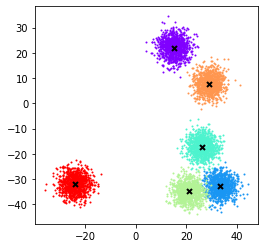

In [14]:
n_clusters = 6
n_samples = 1000

# Generate random points (n_clusters of them) in a 2D plane with coordinates spread between -35 and 35
# These centroids will be the means of the clusters.
centroids = np.random.uniform(-35, 35, (n_clusters, 2))

# Generate Gaussian random numbers for each of the above centroid with a (diagonal) co-variance matrix of [[5 0][0 5]]
slices = [np.random.multivariate_normal(centroids[i], np.diag([10., 10.]), n_samples)
          for i in range(n_clusters)]
# slices is an array of array
data = np.concatenate(slices).astype(np.float32)
# data is a n_samples * n_clusters by 2 array of numbers

# plot the data and centroid
def plot_data(centroids, data, n_samples):
    colors = plt.cm.rainbow(np.linspace(0,1,len(centroids)))
    
    fig, ax = plt.subplots(figsize=(4, 4))
    #for i, centroid in enumerate(centroids):
    for i in range(0, n_clusters) :
        samples = data[i * n_samples : (i + 1) * n_samples] # data for the n-th cluster
        ax.scatter(samples[:, 0], samples[:, 1], color=colors[i], s=1)
        #ax.plot(centroids[i, 0], centroids[i, 1], markersize=10, marker="x", color='k', mew=5)
        ax.plot(centroids[i, 0], centroids[i, 1], markersize=5, marker="x", color='k', mew=2)
    plt.axis('equal')
    
plot_data(centroids, data, n_samples)

# One step of the mean shift for some random samples

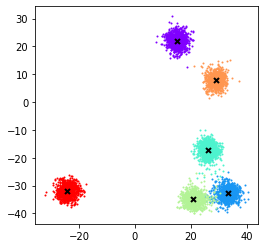

In [15]:
# assume each data point as a potential peak. Compare the spread with above
_X = meanshift_step(np.copy(data), np.copy(data))
plot_data(centroids, _X, n_samples)

Just repeat this/iterate a few times and we have the complete mean shift algorithm:

In [16]:
def meanshift(X, n_iterations):
    X = np.copy(X)
    for _ in range(n_iterations):
        X = meanshift_step(X, X)
    return X

CPU times: user 10.4 s, sys: 2.28 ms, total: 10.4 s
Wall time: 10.5 s


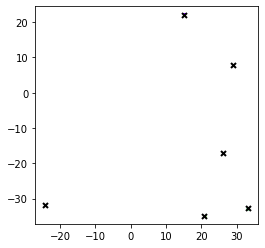

In [17]:
%%time
X = meanshift(data, 5)
plot_data(centroids, X, n_samples)

In [ ]:
def meanshift_random_seeds(X):
    X = np.copy(X)
    index = np.random.choice(X.shape[0], 100*n_clusters, replace=False)  
    cluster_seeds = X[index,:]
    for _ in range(5):
        cluster_seeds = meanshift_step(cluster_seeds, X)
    return cluster_seeds

# Mean shift in PyTorch (with GPU)

PyTorch is like numpy and the interface is very similar.

We actually don't have to adjust anything really to use torch instead of numpy.

In [18]:
import torch

We have to copy the data into a PyTorch GPU tensor and use torch functions for exp, sqrt etc.

In [19]:
def distance(x, X):
    # return np.linalg.norm(x - X, axis=1)
    return torch.sqrt(((x - X)**2).sum(1))

def gaussian(dist, bandwidth):
    return torch.exp(-0.5 * ((dist / bandwidth))**2) / (bandwidth * torch.sqrt(2 * torch.tensor(np.pi)))

def meanshift_torch(X):
    X = torch.from_numpy(np.copy(X)).cuda()
    for it in range(5):
        X = meanshift_step(X, X)
    return X

CPU times: user 10.8 s, sys: 1.55 s, total: 12.3 s
Wall time: 18.1 s


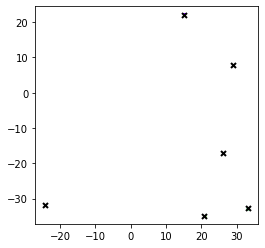

In [20]:
%time X = meanshift_torch(data).cpu().numpy()
plot_data(centroids, X, n_samples)

Same results, but the implementation is about the same speed.

CUDA kernels have to be started for each calculation and the kernels don't have enough to do.
Let's not process individual points, but batches of points.

# Batch processing

In [21]:
#`distance_batch` contains some broadcast magic that allows us to compute the distance from each point in a batch to all points in the data.
# See - https://numpy.org/doc/stable/user/basics.broadcasting.html
#  and https://scipy-lectures.org/intro/numpy/operations.html
def distance_batch(a, b):
    return torch.sqrt(((a[None,:] - b[:,None]) ** 2).sum(2))


# example.
a = torch.rand(2, 2)
b = torch.rand(3, 2)
print(" a=", a, "\n b=", b, "\n", a[None,:], "\n", b[:,None])
d = distance_batch(a, b)
print(d, d.shape)

 a= tensor([[0.9570, 0.7006],
        [0.5009, 0.9639]]) 
 b= tensor([[0.4996, 0.5102],
        [0.2298, 0.9907],
        [0.1620, 0.7188]]) 
 tensor([[[0.9570, 0.7006],
         [0.5009, 0.9639]]]) 
 tensor([[[0.4996, 0.5102]],

        [[0.2298, 0.9907]],

        [[0.1620, 0.7188]]])
tensor([[0.4954, 0.4537],
        [0.7829, 0.2724],
        [0.7952, 0.4183]]) torch.Size([3, 2])


In [22]:
def meanshift_torch2(data, batch_size=500, n_iterations = 5, kernel_width=2.5):
    n = len(data)
    X = torch.from_numpy(np.copy(data)).cuda()
    for _ in range(n_iterations):
        for i in range(0, n, batch_size):
            s = slice(i, min(n, i + batch_size))
            weight = gaussian(distance_batch(X, X[s]), kernel_width)
            num = (weight[:, :, None] * X).sum(dim=1)
            X[s] = num / weight.sum(1)[:, None]
    return X

In [23]:
%time X = meanshift_torch2(data, batch_size=1).cpu().numpy()

CPU times: user 8.33 s, sys: 3.32 ms, total: 8.33 s
Wall time: 8.33 s


In [24]:
%time X = meanshift_torch2(data, batch_size=10).cpu().numpy()

CPU times: user 854 ms, sys: 0 ns, total: 854 ms
Wall time: 857 ms


In [25]:
%time X = meanshift_torch2(data, batch_size=100).cpu().numpy()

CPU times: user 106 ms, sys: 10 ms, total: 116 ms
Wall time: 117 ms


In [26]:
%time X = meanshift_torch2(data, batch_size=1000).cpu().numpy()

CPU times: user 54.3 ms, sys: 38.1 ms, total: 92.4 ms
Wall time: 92.6 ms


In [ ]:
%time X = meanshift_torch2(data, batch_size=12000).cpu().numpy()

CPU times: user 64.4 ms, sys: 46.1 ms, total: 111 ms
Wall time: 112 ms


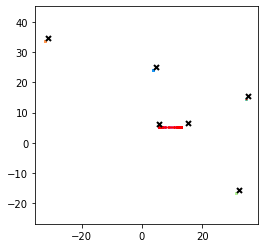

In [ ]:
plot_data(centroids+1, X, n_samples)

# Mean shift in scikit-learn

Of course, sklearn also offers `MeanShift`.
Let's see how it performs

In [ ]:
from sklearn.cluster import MeanShift

In [ ]:
%%time
model = MeanShift()
model.fit(data)

CPU times: user 41.1 s, sys: 285 ms, total: 41.3 s
Wall time: 41.3 s


This is a faster than our naive implementation, but much slower than the GPU version.


# Image Segmentation
We can use meanshift to segment images

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/Colab\ Notebooks/data/house_facade.png


Mounted at /content/drive
'/content/drive/MyDrive/Colab Notebooks/data/house_facade.png'


In [ ]:
def show_pixel_scatter (pixels, n_plot = 1000) : # 2D array of pixel values, one pixel per row
  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  rand_pixels = pixels[np.random.choice(pixels.shape[0], n_plot, replace=False), :]
  ax.scatter(rand_pixels[:,0], rand_pixels[:,1], rand_pixels[:,2])
  ax.set_xlabel('Channel 1')
  ax.set_ylabel('Channel 2')
  ax.set_zlabel('Channel 3')
  plt.show()

def reduce_size (img, scale_percent = 20) :
  #calculate the scale_percent of original dimensions
  width = int(img.shape[1] * scale_percent / 100)
  height = int(img.shape[0] * scale_percent / 100)
  # resize image
  return (cv2.resize(img, (width, height)))


Input image size: (575, 835, 3)
Reduced image size: (115, 167, 3)


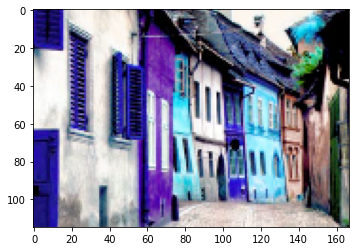

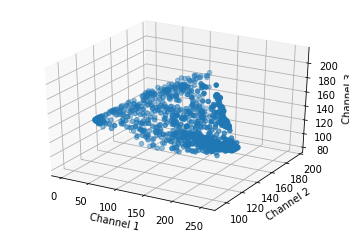

CPU times: user 2.28 s, sys: 2.07 s, total: 4.35 s
Wall time: 4.35 s


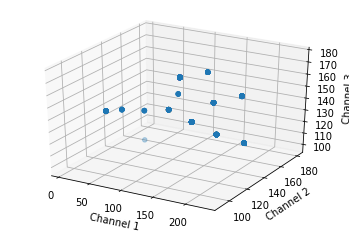

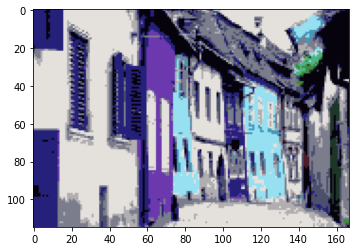

In [ ]:
import cv2

# Load an color image in grayscale
img = cv2.imread('/content/drive/MyDrive/Colab Notebooks/data/house_facade.png')

# Change color spaces. Can experiment with other spaces.
img = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
print("Input image size:", img.shape)

img = reduce_size(img, scale_percent=20)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_LAB2BGR))
print("Reduced image size:", img.shape)

pixels = np.float32(img.reshape((-1,3))) # change the shape of the 2D image into a 1D array
show_pixel_scatter (pixels, n_plot = 1000)

##------------------
%time X = meanshift_torch2(pixels, batch_size=6000, n_iterations=20, kernel_width=10).cpu().numpy()
##------------------

show_pixel_scatter (X, n_plot = 1000)

seg_img = np.uint8(X.reshape(img.shape))
plt.imshow( cv2.cvtColor(seg_img, cv2.COLOR_LAB2BGR))




# Lecture 3 - HW or In-class Assignment #3

1. Conduct ablation study by trying out various combinations of color spaces (BGR, LAB, HCV), kernel_widths (5, 10, 15, 20), n_iterations (20, 100, 200, 500)

2. The above study should reveal that the choice of the kernel_width is critical. Research the literature to find out what strategies have been proposed to choose the kernel_width automatically or at least in an informed mannner.

3. Modify the distance and gaussian kernel computation function to take in a (diagonal) matrix of kernel_width values, not just one scalar number. That is, each dimension, e.g. L, A, and B, can be associated with a different kernel width.

4. Change the code to incorporate a Gaussian kernel over the spatial domain. Comment on the effect.

